In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
#from visualization import visualize, display, sequence_identity
from rdkit.Chem import AllChem
from scipy.stats import spearmanr, ttest_ind

import matplotlib as mpl
font = {'size' : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=1.5)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

#find the column labeled as ['0']
def find_column(df, label):
    for i, col in enumerate(df.columns):
        if col == label:
            return i
    return None

def get_average_accuracy(accuracy_level_list, level):
    """
    returns the average accuracy at a given level
    """
    return np.mean([1 if x >= level else 0 for x in accuracy_level_list])

def expand_list(predicted_ECs):
    """
    for every entry in predicted_ECs, split by ';' and expand the list
    """
    expanded = []
    for entry in predicted_ECs:
        # if entry is a list
        if type(entry) == list:
            print('ERROR: ')
            print(entry)
            return entry
        else:
            expanded.extend(entry.split(';'))
    return expanded

def get_accuracy_level(predicted_ECs, true_ECs):
    """
    based on a list of predicted_ECs, calculates the highest level of accuracy achieved, against all true_ECs. Returns a list of the same length as true_ECs.
    """
    #convert true_EC to a list
    if type(predicted_ECs) == str:
        predicted_ECs = [predicted_ECs]
        
    if type(true_ECs) == str:
        true_ECs = [true_ECs]

    maxes = []
    for true_EC in true_ECs:

        true_split = true_EC.split('.')
        
        counters = []
        for predicted_EC in predicted_ECs:
            try:
                predicted_split = predicted_EC.split('.')
                counter = 0
    
                for predicted, true in zip(predicted_split, true_split):
                    if predicted == true:
                        counter += 1
                    else:
                        break
                counters.append(counter)
                #print(counters)
            except:
                print("ERROR:", predicted_EC)
        
        maxes.append(np.max(counters))
    return maxes
#import umap

#supress warnings
import warnings
warnings.filterwarnings("ignore")

In [12]:
df = pd.read_csv('/disk1/jyang4/repos/CARE/splits/task1/protein_train.csv')
df['EC number'].nunique()

4670

In [13]:
expand_list(['0.0', '2.2;3.3', '4.4'])

['0.0', '2.2', '3.3', '4.4']

### results must be processed into the correct format as csvs under `results_summary`

In [32]:
task1_baselines = ['random', 'BLAST', 'ProteInfer', 'ChatGPT', 'CLEAN']
#task1_baselines = ['ProteInfer']
task1_splits = ['30', '30-50', 'price', 'promiscuous']

task2_baselines = ['random', 'Similarity', 'CLIPZyme', 'CREEP', 'CREEP_text', 'ChatGPT', 'ChatGPT_reaction']
task2_splits = ['easy', 'medium', 'hard']

reference_EC_list = np.loadtxt('processed_data/EC_list.txt', dtype=str)
num_ECs = len(reference_EC_list)

In [3]:
#don't use this anymore ariane put it elsewhere
#generate and save random EC rankings for each task and all splits
# for task in ['task1']:
#     if task == 'task1':
#         baselines = task1_baselines
#         splits = task1_splits
#         modality = 'protein'
#     else:
#         baselines = task2_baselines
#         splits = task2_splits
#         modality = 'reaction'

#     for split in splits:
#         query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, 'CLEAN', split, modality))

#         num_cols = find_column(query_df, '0')
#         print(num_cols)

#         for i in range(query_df.shape[0]):
#             np.random.seed(42)
#             #shuffle the columns
#             query_df.iloc[i, num_cols:] = query_df.iloc[i, num_cols:].sample(frac=1).values
        
#         query_df.to_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, 'Random', split, modality), index=False)

3
3
3
3


In [33]:
results = pd.DataFrame(columns=['baseline', 'split', 'k', 'level 4 accuracy', 'level 3 accuracy', 'level 2 accuracy', 'level 1 accuracy'])

#load the query_df that's already been generated
task  = 'task1'

if task == 'task1':
    baselines = task1_baselines
    splits = task1_splits
    modality = 'protein'
else:
    baselines = task2_baselines
    splits = task2_splits
    modality = 'reaction'

for baseline in baselines:
    for split in splits:

        query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, baseline, split, modality)) #take a different baseline and randomize it
        # if task == 'task1':
        #         num_cols = 3
        # else:
        #     num_cols = len(query_df.columns) - num_ECs
        num_cols = find_column(query_df, '0')
        
        #fill na for columns after num_cols with '0.0.0.0'
        query_df.iloc[:, num_cols:] = query_df.iloc[:, num_cols:].fillna('0.0.0.0')

        # query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, baseline, split, modality))
        # num_cols = sum(isinstance(name, str) for name in query_df.columns)
        # print(num_cols)
        #query_df = query_df.iloc[141:142,:]


        #make a k=1 retrieval accuracy table, broken down by accuracy greater than or equal to level 1, 2, 3, 4

        #change this line if you have fewer rankings available
        for k in [1, 5]:
            #for k in [1, 3, 5, 10, 20, 30, 40, 50]:
            #collapse columns 0:3 into a single column list
            #print(baseline)
            query_df['predicted ECs'] = query_df.iloc[:, num_cols:num_cols+k].values.tolist()
            #for each entry in the list, split out entries that contain ';'
            if baseline == 'BLAST':
                query_df['predicted ECs'] = query_df['predicted ECs'].apply(lambda x: expand_list(x))
                query_df['EC number']

            query_df['EC number list'] = query_df['EC number'].apply(lambda x: x.split(';'))
            
            query_df['k={} accuracy level'.format(k)] = query_df.apply(lambda x: get_accuracy_level(x['predicted ECs'],  x['EC number list']), axis=1)

            accuracies = []
            for i in [4, 3, 2, 1]:
                query_df['accuracy'] = query_df['k={} accuracy level'.format(k)].apply(lambda x: get_average_accuracy(x, i))
                accuracy = query_df['accuracy'].mean()

                #old way of doing it (enzymes with more labels are weighted more heavily)
                # exploded = query_df.explode('k={} accuracy level'.format(k))
                # accuracy = exploded[exploded['k={} accuracy level'.format(k)] >= i].shape[0] / exploded.shape[0]
                
                accuracies.append(round(accuracy*100, 1))
                
            results.loc[len(results)] = [baseline, split, k, accuracies[0], accuracies[1], accuracies[2], accuracies[3]]

In [34]:
results[results['k'] == 1].sort_values(by='split')#[results['split'] != 'promiscuous']

,baseline,split,k,level 4 accuracy,level 3 accuracy,level 2 accuracy,level 1 accuracy
0,random,30,1,0.0,0.6,5.1,21.1
32,CLEAN,30,1,57.7,68.6,73.7,80.6
8,BLAST,30,1,50.3,52.0,55.4,62.3
24,ChatGPT,30,1,0.0,0.0,2.9,16.0
16,ProteInfer,30,1,61.1,65.7,68.6,72.6
34,CLEAN,30-50,1,82.1,91.8,95.4,99.0
26,ChatGPT,30-50,1,0.0,0.0,3.9,14.2
18,ProteInfer,30-50,1,76.5,80.4,83.8,87.3
10,BLAST,30-50,1,70.1,75.5,77.5,80.9
2,random,30-50,1,0.0,0.0,3.9,23.5


In [35]:
results[results['k'] == 5][results['split'] == 'promiscuous']

,baseline,split,k,level 4 accuracy,level 3 accuracy,level 2 accuracy,level 1 accuracy
7,random,promiscuous,5,0.0,6.4,18.5,61.0
15,BLAST,promiscuous,5,94.5,95.0,95.5,98.0
23,ProteInfer,promiscuous,5,76.3,82.2,85.1,89.2
31,ChatGPT,promiscuous,5,1.1,8.3,21.4,47.6
39,CLEAN,promiscuous,5,97.0,98.0,98.3,99.4


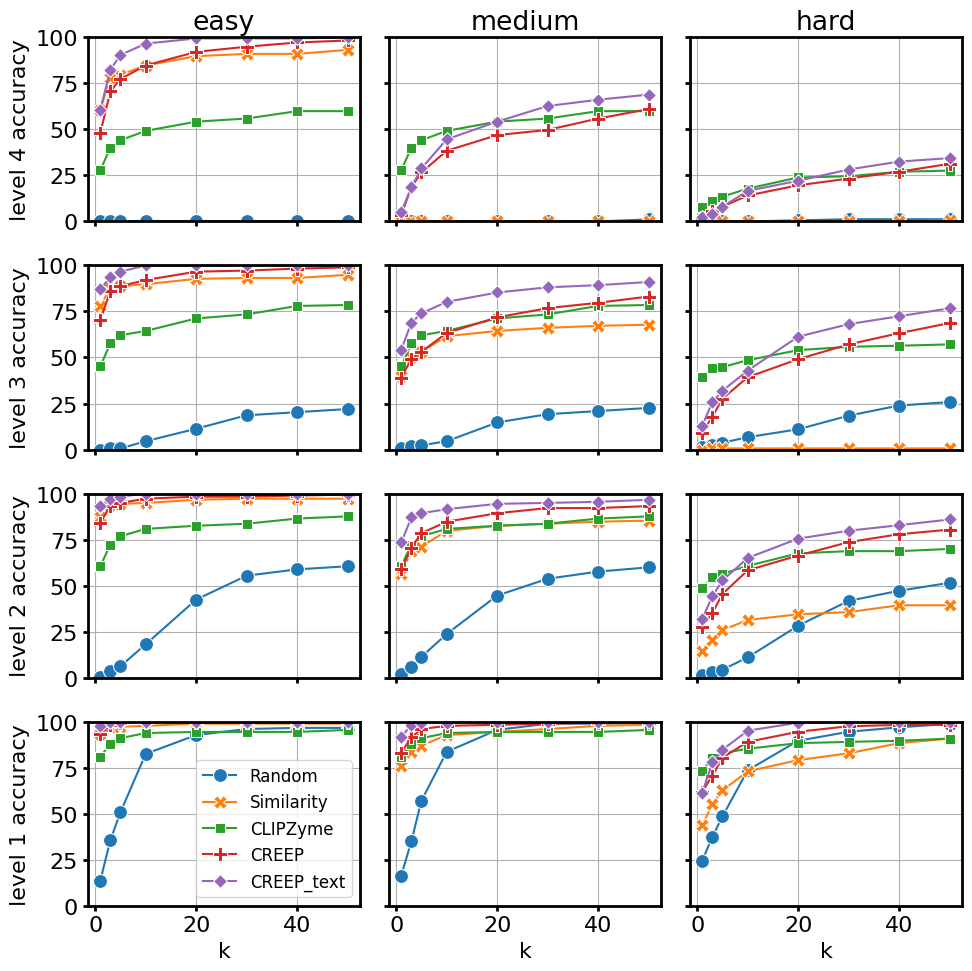

In [21]:
plt.figure(figsize=(10, 10))
i = 0
for metric in ['level 4 accuracy', 'level 3 accuracy', 'level 2 accuracy', 'level 1 accuracy']:
    for split in splits:
        i += 1
        plt.subplot(4, 3, i)
        subset = results[results['split'] == split]
        
        if i == 10:
            sns.lineplot(data=subset, x="k", y=metric, hue="baseline", markers=True, style="baseline", dashes=False, markersize=10, legend=True)
            plt.legend(fontsize=12, title='')
        else:
            sns.lineplot(data=subset, x="k", y=metric, hue="baseline", markers=True, style="baseline", dashes=False, markersize=10, legend=False)
            
            #change legend font size

        if i <= 3:
            plt.title(split)
        #remove the ylabel and y axis tick labels for all but the left subplots
        if i % 3 != 1:
            plt.ylabel('')
            ax = plt.gca()
            ax.set_yticklabels('')
            #plt.set_xticklabels(None)
        #remove the xlabel and x axis ticks for all but the bottom subplots
        if i < 10:
            plt.xlabel('')
            ax = plt.gca()
            ax.set_xticklabels('')

        plt.grid(True)
        plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('generate_datasets_splits/figs/lineplots.png', dpi=500)

### Measure similarity to reactions in the train set

In [16]:
results = pd.DataFrame()
for split in ['easy', 'medium', 'hard']:
    reaction_similarities = np.load('/disk1/jyang4/repos/CARE/task2_baselines/Similarity/output/{}_split/retrieval_results/{}_reaction_test_reaction2reaction_retrieval_similarities.npy'.format(split, split))
    query_df = pd.read_csv('task2_baselines/results_summary/CREEP/{}_reaction_test_results_df.csv'.format(split))
    reference_df = pd.read_csv('splits/task2/{}_reaction_train.csv'.format(split))

    query_df['Correct'] = query_df['EC number'] == query_df['0']
    #apply get accuracy level
    query_df['k=1 accuracy level'] = query_df.apply(lambda x: get_accuracy_level(x['0'], x['EC number'])[0], axis=1)
    query_df['Similarity'] = np.max(reaction_similarities, axis=1)
    query_df = query_df.sort_values(by='Similarity', ascending=False)
    query_df['Split'] = split
    results = pd.concat([results, query_df], axis=0)
results

,Reaction,Mapped Reaction,EC number,Reaction Text,EC3,EC2,EC1,Duplicated EC,Reactions with a single EC,0,...,4667,4668,4669,4670,4671,4672,Correct,k=1 accuracy level,Similarity,Split
79,CC(O)[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc1cc...,[CH3:1][CH:2]([OH:3])[C@H:4]([NH:5][C:6](=[O:7...,2.7.14.1,ATP + a [protein]-L-arginine = ADP + a [protei...,2.7.14,2.70,2,True,1,2.7.11.19,...,3.1.1.105,2.1.1.278,4.2.1.105,2.1.1.50,4.2.99.23,4.2.99.22,False,2,1.0,easy
159,C/C(=C\C(=O)O)C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(...,[CH3:1]/[C:2](=[CH:3]\[C:4](=[O:5])[OH:6])[C:7...,5.4.1.3,2-methylfumaryl-CoA = 3-methylfumaryl-CoA {r},5.4.1,5.40,5,True,1,5.4.1.3,...,3.2.1.123,3.5.1.101,2.4.1.68,3.5.1.105,3.2.1.99,3.5.1.125,True,4,1.0,easy
35,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,[H+].[NH2:1][C:2](=[O:3])[C:4]1=[CH:5][N:6]([C...,1.21.4.1,D-proline + NADH = 5-aminopentanoic acid + NAD+,1.21.4,1.21,1,True,1,1.21.4.1,...,5.3.99.11,4.1.3.32,4.99.1.8,6.5.1.4,6.5.1.5,2.4.1.290,True,4,1.0,easy
82,Nc1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@...,[NH2:1][c:2]1[cH:3][cH:4][n:5]([C@@H:6]2[O:7][...,2.7.4.10,CTP + AMP = CDP + ADP {r},2.7.4,2.70,2,True,1,2.7.4.8,...,3.1.1.87,3.1.1.72,3.1.1.1,3.1.1.73,4.2.99.23,4.2.99.22,False,3,1.0,easy
41,C=CC1=C(C)C(CC2=N/C(=C3\c4[nH]c(Cc5[nH]c(C=O)c...,[CH2:1]=[CH:2][C:3]1=[C:4]([CH3:5])[CH:6]([CH2...,1.3.7.12,primary fluorescent chlorophyll catabolite + N...,1.3.7,1.30,1,True,1,1.3.7.12,...,3.1.3.22,1.14.11.46,3.1.3.63,1.14.11.71,3.1.3.3,3.1.3.50,True,4,1.0,easy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc...,[CH3:1][C:2]([CH3:3])([CH2:4][O:5][P:6](=[O:7]...,1.2.7.4,propionyl-SCoA + CoASH = propionyl-SCoA + CoAS...,1.2.7,1.20,1,True,1,2.3.1.155,...,3.2.1.24,3.2.1.11,1.1.3.5,3.2.1.57,5.5.1.20,1.1.3.42,False,0,0.0,hard
128,C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5nc(cc1[nH]2)C(C)=...,[CH2:1]=[CH:2][c:3]1[c:4]([CH3:5])[c:6]2[cH:7]...,4.99.1.9,protoporphyrin IX + Cu2+ = Cu-protoporphyrin I...,4.99.1,4.99,4,True,1,1.5.99.15,...,2.4.1.13,1.14.15.35,6.3.1.1,2.3.1.109,2.3.2.30,2.4.1.245,False,0,0.0,hard
127,C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5nc(cc1[nH]2)C(C)=...,[CH2:1]=[CH:2][c:3]1[c:4]([CH3:5])[c:6]2[cH:7]...,4.98.1.1,Cd2+-protoporphyrin + H+ = protoporphyrin + Cd2+,4.98.1,4.98,4,True,1,3.5.4.27,...,2.3.1.183,2.3.1.271,2.3.1.53,2.7.1.157,2.3.1.109,2.3.2.30,False,0,0.0,hard
78,O.O=C(O)[C@H]1O[C@H](O[C@@H]2[C@H](O)[C@@H](O)...,[O:2]=[C:3]([OH:4])[C@H:5]1[O:6][C@H:7]([O:8][...,3.2.1.15,"alpha-D-galacturonosyl-(1,4)-O-alpha-D-galactu...",3.2.1,3.20,3,True,1,3.2.1.40,...,2.7.14.1,2.7.4.16,2.7.1.39,2.1.1.5,2.7.3.3,2.1.1.258,False,3,0.0,hard


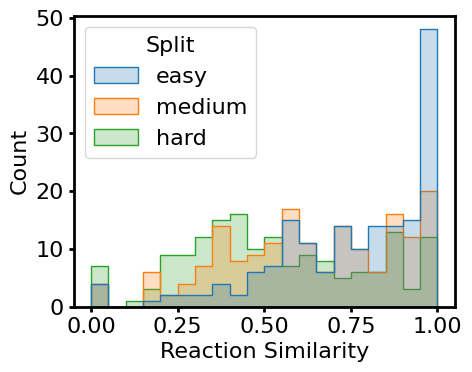

In [7]:
plt.figure(figsize=(5, 4))
sns.histplot(results, x='Similarity', hue='Split', element="step",stat="count", bins=20, fill=True)
sns.move_legend(plt.gca(), "upper left")
plt.xlabel('Reaction Similarity')
plt.tight_layout()
plt.savefig('generate_datasets_splits/figs/task2_similarity_histogram.png', dpi=500)

### Visualize if predictions on the more similar reactions are more accurate

Ttest_indResult(statistic=5.104055220328118, pvalue=4.6850408074296735e-07)


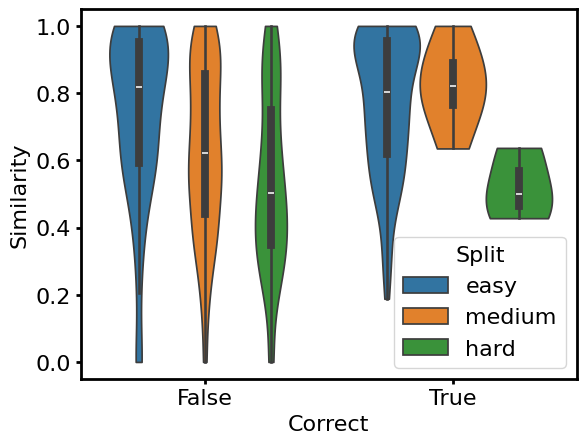

In [17]:
#calculate the correlation between correct and reaction similarity
#print(spearmanr(merged['reaction_similarity'],merged['correct']))
#subset = results[results['Split'] == 'hard']
print(ttest_ind(results[results['Correct']]['Similarity'], results[~results['Correct']]['Similarity']))
sns.violinplot(data=results, x='Correct', y='Similarity', hue='Split', cut=False)

SpearmanrResult(correlation=0.2997393476798378, pvalue=3.4144401043179985e-12)


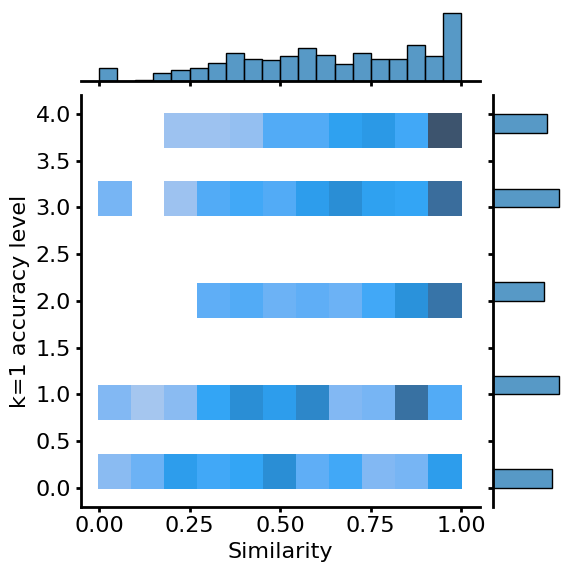

In [25]:
print(spearmanr(results['Similarity'], results['k=1 accuracy level']))
sns.jointplot(data=results, x='Similarity', y='k=1 accuracy level', kind='hist', marginal_kws=dict(bins=20, fill=True))


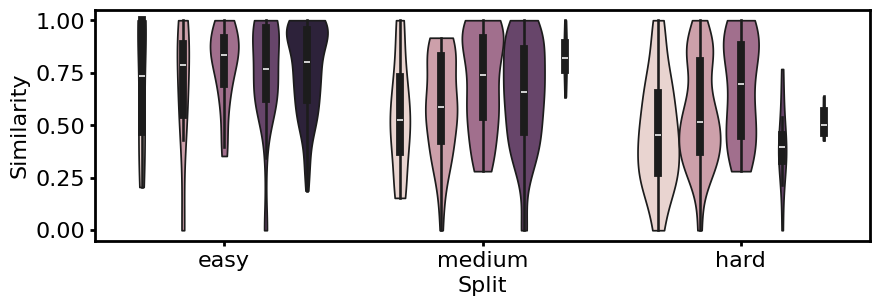

In [37]:
plt.figure(figsize=(10, 3))
sns.violinplot(data=results, x='Split', y='Similarity', hue='k=1 accuracy level', cut=False, legend=False, density_norm="count")

### Visualize some of the reactions with highest and lowest similarity

The most recent query_df should be for the hard set

In [43]:
query_df

,Reaction,Mapped Reaction,EC number,Reaction Text,EC3,EC2,EC1,Duplicated EC,Reactions with a single EC,0,...,4666,4667,4668,4669,4670,4671,4672,Correct,Similarity,Split
77,N[C@@H](CCS)C(=O)O.O=c1[nH]cnc2c1ncn2[C@@H]1O[...,[NH2:1][C@@H:2]([CH2:3][CH2:4][SH:5])[C:6](=[O...,3.13.1.9,S-inosyl-L-homocysteine + H2O = inosine + L-ho...,3.13.1,3.13,3,True,1,3.5.4.28,...,1.6.3.2,1.8.1.18,2.7.8.23,5.4.99.2,5.4.2.9,3.7.1.1,3.11.1.3,False,1.0,hard
94,Nc1ncnc2c1ncn2[C@H]1CC[C@@H](COP(=O)(O)OP(=O)(...,[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8]...,3.6.4.13,"2',3'-dideoxy-ATP + H2O = 2',3'-dideoxy-ADP + ...",3.6.4,3.60,3,True,1,3.6.1.6,...,2.3.1.248,2.3.1.133,2.3.1.184,2.3.2.30,2.3.1.302,2.3.1.144,2.3.1.28,False,1.0,hard
146,CNc1ccccc1C(=O)O[C@H]1[C@@H](O)[C@H](n2cnc3c(N...,[CH3:1][NH:2][c:3]1[cH:4][cH:5][cH:6][cH:7][c:...,5.6.2.4,2'(3')-O-(N-methylanthraniloyl)ATP + H2O = 2'(...,5.6.2,5.60,5,True,1,3.6.5.3,...,4.1.1.19,2.3.1.109,1.8.1.19,4.1.1.17,2.1.4.1,2.1.4.3,2.1.4.2,False,1.0,hard
31,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,[NH2:1][C:2](=[O:3])[C:4]1=[CH:5][N:6]([C@@H:7...,1.6.1.1,NADH + 3'-NADP+ = NAD+ + 3'-NADPH,1.6.1,1.60,1,True,1,2.7.1.23,...,2.1.1.141,1.13.12.5,3.7.1.8,3.7.1.14,3.8.1.5,3.7.1.25,3.7.1.9,False,1.0,hard
65,CC(C)C[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@@H](N)C...,[CH3:1][CH:2]([CH3:3])[CH2:4][C@H:5]([NH:6][C:...,2.7.11.13,ATP + FKLKRKGSFKKFA = ADP + FKLKRKGpSFKKFA,2.7.11,2.70,2,True,1,2.7.12.1,...,3.1.1.6,3.1.1.56,3.1.1.104,3.1.1.72,3.1.1.25,4.2.1.53,3.1.8.1,False,1.0,hard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc...,[CH3:1][C:2]([CH3:3])([CH2:4][O:5][P:6](=[O:7]...,1.2.7.4,propionyl-SCoA + CoASH = propionyl-SCoA + CoAS...,1.2.7,1.20,1,True,1,2.3.1.155,...,1.17.9.1,3.2.1.24,3.2.1.11,1.1.3.5,3.2.1.57,5.5.1.20,1.1.3.42,False,0.0,hard
128,C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5nc(cc1[nH]2)C(C)=...,[CH2:1]=[CH:2][c:3]1[c:4]([CH3:5])[c:6]2[cH:7]...,4.99.1.9,protoporphyrin IX + Cu2+ = Cu-protoporphyrin I...,4.99.1,4.99,4,True,1,1.5.99.15,...,2.7.1.6,2.4.1.13,1.14.15.35,6.3.1.1,2.3.1.109,2.3.2.30,2.4.1.245,False,0.0,hard
127,C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5nc(cc1[nH]2)C(C)=...,[CH2:1]=[CH:2][c:3]1[c:4]([CH3:5])[c:6]2[cH:7]...,4.98.1.1,Cd2+-protoporphyrin + H+ = protoporphyrin + Cd2+,4.98.1,4.98,4,True,1,3.5.4.27,...,2.4.1.245,2.3.1.183,2.3.1.271,2.3.1.53,2.7.1.157,2.3.1.109,2.3.2.30,False,0.0,hard
78,O.O=C(O)[C@H]1O[C@H](O[C@@H]2[C@H](O)[C@@H](O)...,[O:2]=[C:3]([OH:4])[C@H:5]1[O:6][C@H:7]([O:8][...,3.2.1.15,"alpha-D-galacturonosyl-(1,4)-O-alpha-D-galactu...",3.2.1,3.20,3,True,1,3.2.1.40,...,2.7.4.26,2.7.14.1,2.7.4.16,2.7.1.39,2.1.1.5,2.7.3.3,2.1.1.258,False,0.0,hard


In [65]:
rxns = []
rxn2s = []
for index in query_df.index:
    rxn = query_df['Reaction'].values[index]
    EC_number = query_df['EC number'].values[index]
    predicted_EC_number = query_df['0'].values[index]

    reference_subset = reference_df[reference_df['EC number'] == predicted_EC_number]
    if len(reference_subset) == 1:
        rxn2 = reference_subset['Reaction'].values[0]
        
        rxns.append(rxn)
        rxn2s.append(rxn2)

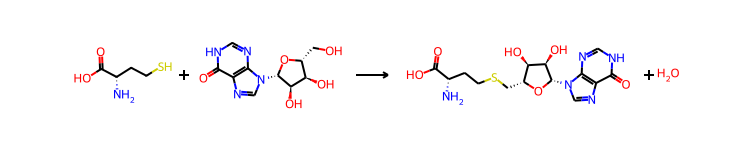

In [77]:
index=0
AllChem.ReactionFromSmarts(rxns[index], useSmiles=True)

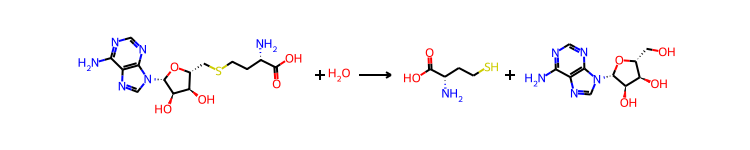

In [78]:
AllChem.ReactionFromSmarts(rxn2s[index], useSmiles=True) 